### 从零实现线性回归

#### 基础操作定义

In [2]:
import random
import torch
from matplotlib import pyplot as plt
import os

# 避免当下版本matplotlib与pytorch的冲突
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

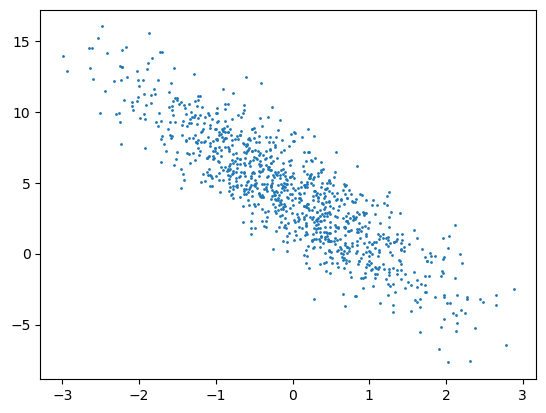

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
plt.show()

In [4]:
def data_iter(batch_size, features, labels):
    """
    随机采样
    :param batch_size: 随机样本大小
    :param features: 数据集
    :param labels: 数据集对应的标签
    :return: 随机样本
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的,没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

#### 模型定义

In [22]:
# 初始化模型参数
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重,并将偏置初始化为0
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


# 定义线性回归模型
def lin_reg(X, w, b):
    return torch.matmul(X, w) + b


# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


# 定义优化算法: 小批量随机梯度下降
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 训练模型

In [24]:
def train(lr, num_epochs, batch_size, net, loss):
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            # X和y的小批量损失
            l = loss(net(X, w, b), y)

            # l的形状是(batch_size, 1)，而不是一个标量
            # l中的所有元素被加到一起，并以此计算关于[`w`, `b`]的梯度
            l.sum().backward()

            # 使用参数的梯度更新参数
            sgd([w, b], lr, batch_size)
        # 接下来的计算不需要梯度,所以使用语句with torch.no_grad():
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


train(0.2, 10, 10, lin_reg, squared_loss)
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.000051
epoch 2, loss 0.000052
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000052
epoch 6, loss 0.000052
epoch 7, loss 0.000050
epoch 8, loss 0.000051
epoch 9, loss 0.000050
epoch 10, loss 0.000051
w的估计误差: tensor([0.0002, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0005], grad_fn=<RsubBackward1>)


### 简洁实现